# Introduction to PyTorch
If you don't know sth, check it in documentation > tutorial > google (PyTorch {problem name}) > ask teacher. 

Note: tensors dimensions:
[batch, channels, Optional(height), Optional(width)]

In [1]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


1. To train and testing of networks, we use `MINIST` dataset.

For train dataset apply augmentation transformations like: random rotation, blur, random equalize (if available), random affine transform.

For both apply ToTensor.

To use multiple transforms use `Compose` container.

Use proper transforms parameters.

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

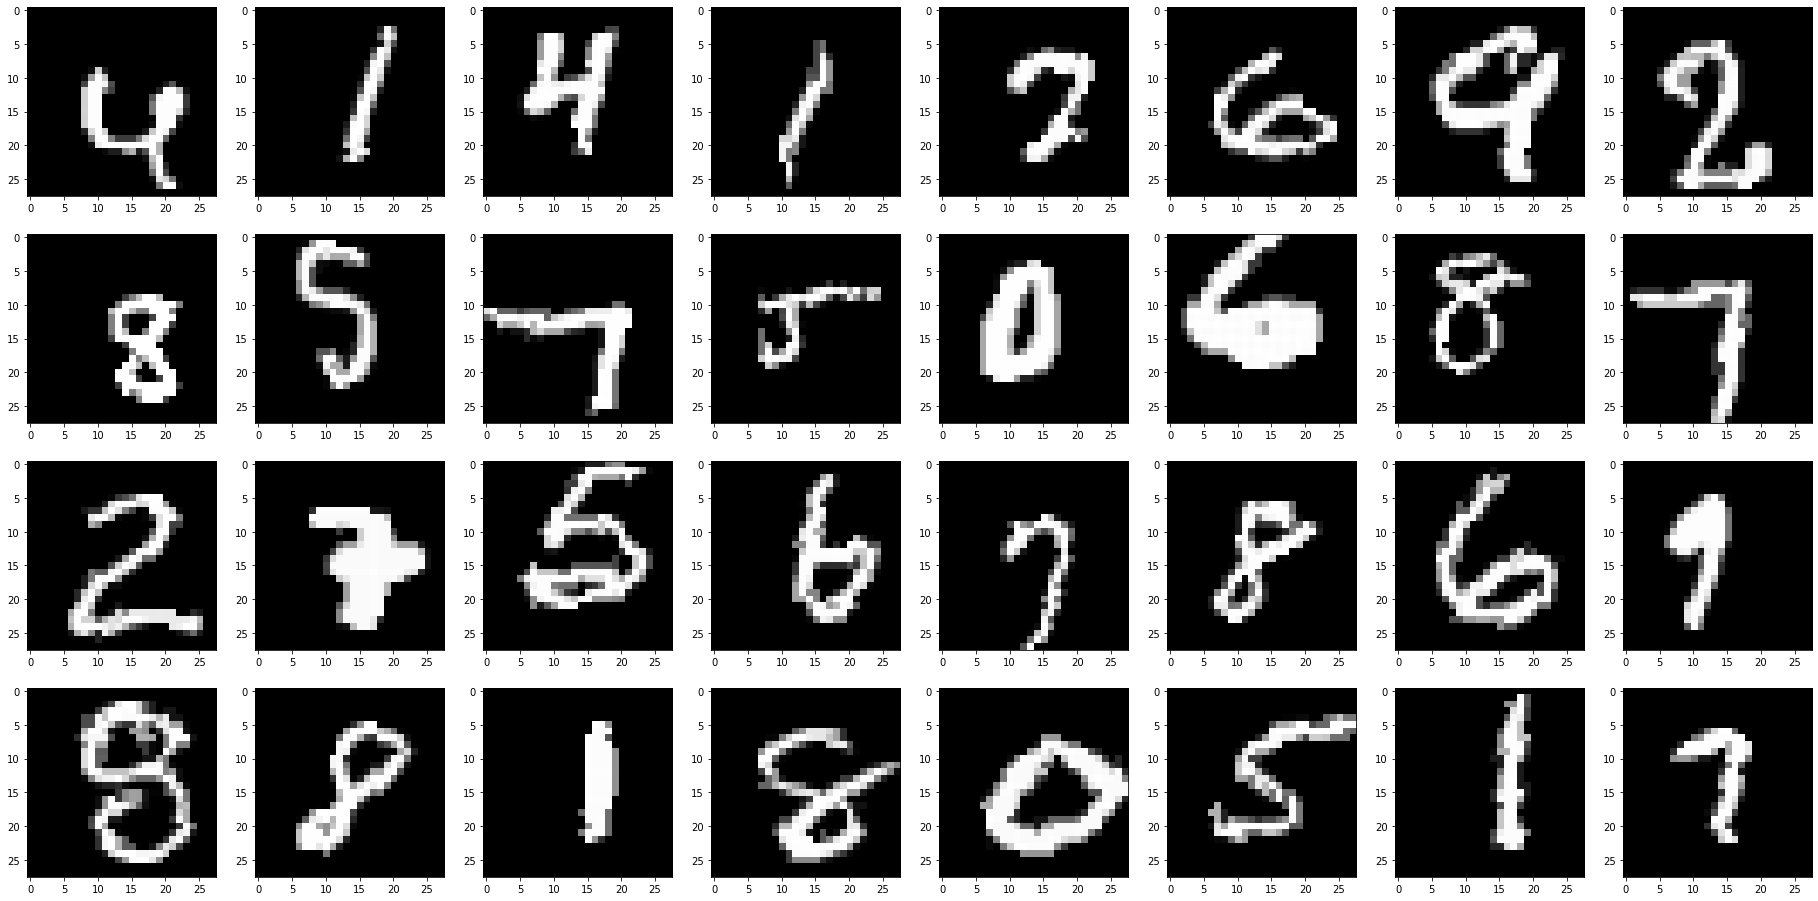

In [3]:
from torchvision.transforms import ToTensor, Compose, RandomAffine, RandomRotation
# Could be not available - depends on the torch version
# from torchvision.transforms import RandomEqualize

transforms = ...

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=transforms)
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=64,
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                          batch_size=64,
                          shuffle=False)

print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 4, 8
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.permute(1,2,0))
    plt.show()
            
    break
        

2. Convolution:

Convolution is one of the basic (and the most important) operations in computer vision -  image filtration. 

That operation allows for analysis of the context of all pixels in the same manner.

We can imagine it as a dot product between neighborhood's pixels and their weights.

Weights can be different for each of neighborhood's pixel, 

but the same for different context - are not dependent on position of analyzed context.


Please, instantiate `Conv2d` module with single input and output channel, 

kernel size 3, stride 1, without padding and without bias.

Try different configurations (independently):
- with and without padding,
- kernel size: (3,3), (5,5),
- stride: 1, 2, 3,

Initial (or own) layers' weights normalize to range $[-1; 1]$ 
-if included values are out of this range .

For tests use single image from training dataset.

Pass forward through the layer with context manager `torch.no_grad`
or apply `requires_grad_(False)` on layers ( it's a method of torch.nn.Module). 

Display original image, results of layer processing and numbers of parameters.  

There could be needed outputs normalization for proper display.


Hint: You can use for loops :)

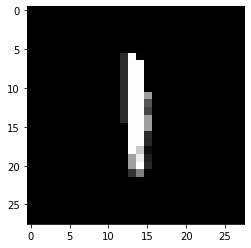

Layer0:
L0.weight.shape:
torch.Size([1, 1, 3, 3])
L0.weight
Parameter containing:
tensor([[[[ 0.,  1.,  0.],
          [ 1.,  0., -1.],
          [ 0., -1.,  0.]]]])


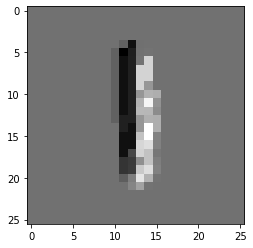

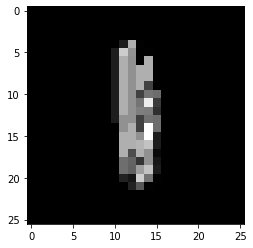

Ellipsis

In [24]:
# example weights change
# with torch.no_grad():
#     print(conv.weight)
#     conv.weight[:] *= 0.0
#     conv.weight[:] = 1.0
#     print(conv.weight)

def display_tensor_as_img(t: torch.Tensor):
    plt.imshow(t.reshape(t.shape[-2:]))
    plt.show()

input_tensor = next(iter(train_loader))[0][:1,...]

to_display = input_tensor[0:1,0:1,...] # [take a batch with size one, take a single channel, take the rest dimensions (dim 2 and 3)]
display_tensor_as_img(to_display)

##############
print('Layer0:')
L0 = nn.Conv2d(1,1,3, bias=False)
L0.requires_grad_(False)
# example of weight setting: filter for detection of oblique edges
L0.weight.flatten()[:] = torch.tensor([0,1,0,1,0,-1,0,-1,0])
print("L0.weight.shape:")
print(L0.weight.shape)
print("L0.weight")
print(L0.weight)

y0 = L0(input_tensor)
display_tensor_as_img(y0[0:1,0:1,...]) # visualization: negative is black positive is white
# positive value: detection of edge same as the filter
# negative value: detection of edge inverse to the filter
display_tensor_as_img(y0[0:1,0:1,...].abs()) # visualization: white are the values much more higher than 0.0

# Yours experiments with different layer's parameters:
...


3. Convolution - multichannel:

Now, try to concatenate two different images into tensor of two channels.

Create two `Conv2d` layers with two input channels.

For first use single output channel, for second use two of more output channels.

Pass input tensor through the layers and display results.

Each of output channels separately.


4. Basically increasing the depth of the network allows for better generalization and extraction of more complex features.

Unfortunately, if network is deeper than 8 layers, [gradient degradation](https://medium.com/@shaoliang.jia/vanishing-gradient-vs-degradation-b719594b6877) appears.

One of the solution, to prevent mentioned phenomenon, is applying residual connections.

The first networks, where this type of connection appeared, is [ResNet](https://arxiv.org/pdf/1512.03385.pdf).

Prepare residual block model which implements function:

$ResidualBlock(x) = x + F_1(F_2(x))$

Define a class `ResidualBlock`:
- as a derived class of `nn.Module`,
- with constructor's arguments: 
    - input_channels, 
    - intermediate_channels, 
    - kernel_size
- for functions $F_1$ and $F_2$ instantiate sequential model of:
    - 2d convolution (with padding, without bias)
    - batch normalization
    - ReLU activation
- what is the proper number of channels for second convolution 
    (hint: addition should be elementwise)?
- block's layer-to-layer processing define in `forward` method.

Note: number of layer's input channels must be the same as the previous layer's output channels.

Note: each layer should have it's own instance of `nn.Conv2d`, 
because they need to have their own parameters.

Instantiate defined block as a test. 

5. Define the `MiniResNet`network with the following layers (in sequential order):
    - conv2d kernel=3, filers=16, padding
    - relu
    
    - ResidualBlock, kernel=3, intermediate channels = 4
    
    - conv2d kernel=3, filers=32, padding
    - relu
    - maxpool2d kernel=2, stride=2
    
    - ResidualBlock, kernel=3, intermediate channels = 4
    - ResidualBlock, kernel=3, intermediate channels = 2
    
    - conv2d kernel=3, filers=64, padding
    - relu
    - maxpool2d kernel=2, stride=2
    
    - ResidualBlock, kernel=3, intermediate channels = 8
    - ResidualBlock, kernel=3, intermediate channels = 16
    
    - conv2d kernel=3, filers=128, without padding
    - relu
    
    - conv2d kernel=3, filers=128, without padding
    - relu
    
    - flatten
    - linear layer with 10 outputs (input channels designate based on network architecture: strides, paddings -> 128*3*3)
    - softmax function
    
Instantiate network, calculate number of parameters, train, plot training history and save network to file.

Note: filters in this context is the same as output channels.
Note: each layer needs it's own instance

P.S. 1 You can change training and layers parameters, but use proposed architecture.

P.S. 2 Use criterion, metric and optimizer the same as was "done" on previous labs :)

6. You can leave a feedback, if you want :)

7. Exercises please upload this file (*.ipynb) to UPEL.